Create LSTM model using dyanamic Data

In [1]:
import pandas as pd
import numpy as np

import yfinance as yf

import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

Training Data from 2010-2019

In [2]:
start_date = '2010-12-31'
end_date = '2019-12-31'

trainingData = yf.download( '^NSEI' , start = start_date, end = end_date)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,6105.100098,6147.299805,6103.549805,6134.500000,6134.500000,0
2011-01-03,6177.450195,6178.549805,6147.200195,6157.600098,6157.600098,0
2011-01-04,6172.750000,6181.049805,6124.399902,6146.350098,6146.350098,0
2011-01-05,6141.350098,6141.350098,6062.350098,6079.799805,6079.799805,0
2011-01-06,6107.000000,6116.149902,6022.299805,6048.250000,6048.250000,0


Testing Data from 2020 to 2023

In [3]:
start_date = '2020-1-2'
end_date = '2023-12-31'

testingData = yf.download('^NSEI', start = start_date, end =  end_date)
testingData.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,12198.549805,12289.900391,12195.250000,12282.200195,12282.200195,407700
2020-01-03,12261.099609,12265.599609,12191.349609,12226.650391,12226.650391,428800
2020-01-06,12170.599609,12179.099609,11974.200195,11993.049805,11993.049805,396500
2020-01-07,12079.099609,12152.150391,12005.349609,12052.950195,12052.950195,447800
2020-01-08,11939.099609,12044.950195,11929.599609,12025.349609,12025.349609,446000


In [4]:
trainClose = trainingData['Adj Close']
trainraw = trainClose.values

testClose = testingData['Adj Close']
testraw = testClose.values


# testingData(fetched from yfinance ) => trainClose(series, Adjusted Close) => trainraw (array, values) => trainrawscaled
# trainingData                        => trainprice                         => trainData                => trainDataScaled

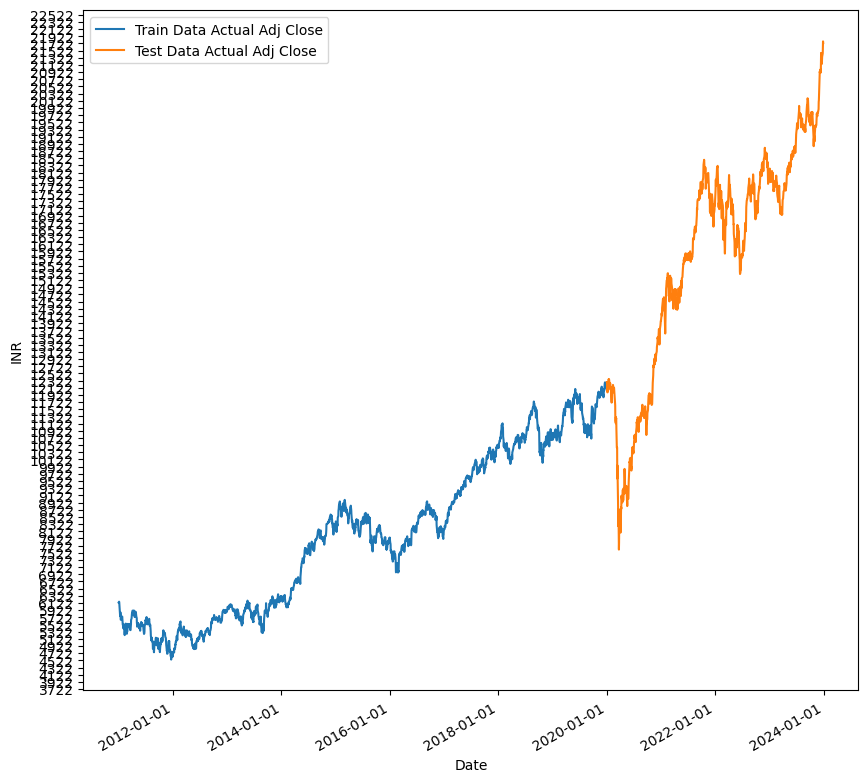

In [5]:
plt.figure(figsize=(10,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_locator(mdates.DayLocator(interval=200))

plt.plot(trainingData.index, trainingData['Adj Close'], label='Train Data Actual Adj Close')
plt.plot(testingData.index, testingData['Adj Close'], label='Test Data Actual Adj Close')
plt.xlabel('Date')
plt.ylabel('INR')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [6]:
minmax = MinMaxScaler(feature_range=(0,1))
trainrawscaled = minmax.fit_transform(trainraw.reshape(-1, 1))
testrawscaled = minmax.fit_transform(testraw.reshape(-1, 1))

In [7]:
n_steps = 20

x_train, y_train = [], []

for i in range(n_steps, len(trainrawscaled)):
    x_train.append(trainrawscaled[i-n_steps:i, 0])
    y_train.append(trainrawscaled[i, 0])
      
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
#LSTM Model init

model = Sequential()

#Layer 1
model.add(LSTM(units=200,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 4
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 20, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_1 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               3

In [9]:
#Method to plot the training metric vs validation metric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [10]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(x_train, y_train)

68/68 [==============================] - 4s 21ms/step - loss: 0.2716 - root_mean_squared_error: 0.5211 - mean_absolute_error: 0.4422


Epoch 1/100
13/13 [==============================] - 13s 173ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - mean_absolute_error: 0.0625 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0750 - val_mean_absolute_error: 0.0648
Epoch 2/100
13/13 [==============================] - 2s 164ms/step - loss: 0.0324 - root_mean_squared_error: 0.1800 - mean_absolute_error: 0.1453 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2238 - val_mean_absolute_error: 0.2187
Epoch 3/100
13/13 [==============================] - 2s 166ms/step - loss: 0.0320 - root_mean_squared_error: 0.1789 - mean_absolute_error: 0.1467 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183 - val_mean_absolute_error: 0.1103
Epoch 4/100
13/13 [==============================] - 3s 209ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942 - mean_absolute_error: 0.1683 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810 - val_mean_absolute_error: 0.0701
Epoch 5/100
13/13 [==============================] 

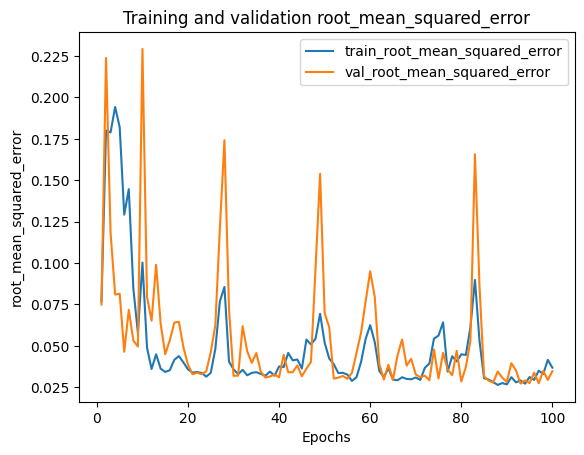

In [11]:
log = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=128, 
    validation_split = 0.25, 
    verbose=1, 
    callbacks=[earlyStopping], 
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [12]:
n_steps = 20

x_test = []
y_test = []

for i in range(n_steps, len(testrawscaled)):
    x_test.append(testrawscaled[i-n_steps:i, 0])
    y_test.append(testrawscaled[i, 0])
      
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
predictions = model.predict(x_test) #Prediction on Data using trained model
output = minmax.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, y_test)) #Calculating of RMSE
print(rmse)

31/31 [==============================] - 3s 21ms/step
0.03342715474627884


In [14]:
eval = model.evaluate(x_test, y_test)

31/31 [==============================] - 1s 21ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - mean_absolute_error: 0.0252


Creating a single dataframe

In [15]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)

In [16]:
df = df1.join(df2).set_index('Date')
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,12282.200195,12484.590820
2020-01-03,12226.650391,12466.220703
2020-01-06,11993.049805,12444.688477
2020-01-07,12052.950195,12412.448242
2020-01-08,12025.349609,12376.990234
...,...,...
2023-11-23,19802.000000,20584.396484
2023-11-24,19794.699219,20629.404297
2023-11-28,19889.699219,20669.162109


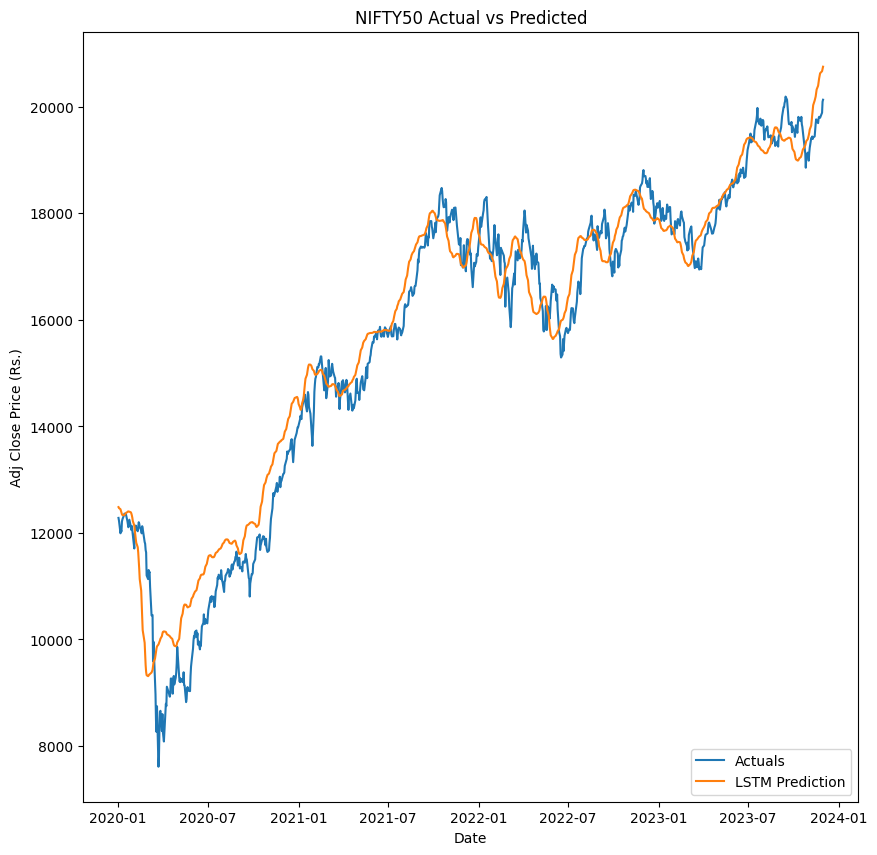

In [17]:
real = df['Adj Close']
pred = df['Pred Adj Close']
dig = plt.figure(figsize=(10,10))
plt.title('NIFTY50 Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price (Rs.)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actuals','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

dig.savefig('predictedVSactuals.png')